[01/20/25 22:15:20] WARNING  Your inference package version 0.33.0 is out of date! Please upgrade to ]8;id=271493;file:///opt/anaconda3/envs/zeel_py310/lib/python3.10/site-packages/inference/core/__init__.py\__init__.py]8;;\:]8;id=536110;file:///opt/anaconda3/envs/zeel_py310/lib/python3.10/site-packages/inference/core/__init__.py#41\41]8;;\
                             version 0.34.0 of inference for the latest features and bug fixes by                  
                             running `pip install --upgrade inference`.                                            

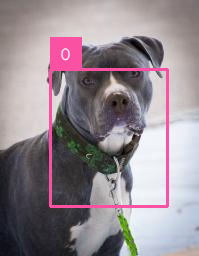

2025-01-20 22:15:22.319412181 [E:onnxruntime:Default, provider_bridge_ort.cc:1862 TryGetProviderInfo_CUDA] /onnxruntime_src/onnxruntime/core/session/provider_bridge_ort.cc:1539 onnxruntime::Provider& onnxruntime::ProviderLibrary::Get() [ONNXRuntimeError] : 1 : FAIL : Failed to load library libonnxruntime_providers_cuda.so with error: libcudnn_adv.so.9: cannot open shared object file: No such file or directory

2025-01-20 22:15:22.319453861 [W:onnxruntime:Default, onnxruntime_pybind_state.cc:993 CreateExecutionProviderInstance] Failed to create CUDAExecutionProvider. Require cuDNN 9.* and CUDA 12.*. Please install all dependencies as mentioned in the GPU requirements page (https://onnxruntime.ai/docs/execution-providers/CUDA-ExecutionProvider.html#requirements), make sure they're in the PATH, and that your GPU is supported.


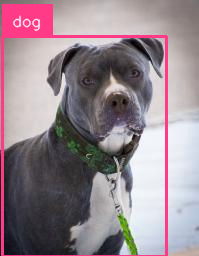

In [47]:
import requests
from io import BytesIO
from PIL import Image
import numpy as np
import supervision as sv
from inference.models.utils import get_roboflow_model

# Create a dummy dataset
data = requests.get("https://raw.githubusercontent.com/jigsawpieces/dog-api-images/main/pitbull/dog-3981033_1280.jpg")
image = Image.open(BytesIO(data.content)).reduce(5)
label = np.random.rand(1, 5) / 10 + 0.5
label[:, 0] = 0
!mkdir -p /tmp/dummy_dataset/images
!mkdir -p /tmp/dummy_dataset/labels
image.save("/tmp/dummy_dataset/images/0.jpg")
np.savetxt("/tmp/dummy_dataset/labels/0.txt", label, fmt="%d %f %f %f %f")
with open("/tmp/dummy_dataset/dataset.yml", "w") as f:
    f.write("""train: _
val: _
test: _
nc: 1
names: ["dummy"]""")

# Load as supervision dataset
dataset = sv.DetectionDataset.from_yolo("/tmp/dummy_dataset/images", "/tmp/dummy_dataset/labels", "/tmp/dummy_dataset/dataset.yml")

# Visualize the first instance
image_path, image, detection = dataset[0]
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()
annotated_image = box_annotator.annotate(image.copy(), detection)
annotated_image = label_annotator.annotate(annotated_image, detection)
display(Image.fromarray(annotated_image))

# Visualize the prediction
model = get_roboflow_model("yolov8s-640")
prediction = model.infer(image)[0]
detection = sv.Detections.from_inference(prediction)
annotated_image = box_annotator.annotate(image.copy(), detection)
annotated_image = label_annotator.annotate(annotated_image, detection)
display(Image.fromarray(annotated_image))

# Modified the detection to display class name
# image_path, image, detection = dataset[0]
# detection.data = {"class_name": np.array(['dummy'])}
# box_annotator = sv.BoxAnnotator()
# label_annotator = sv.LabelAnnotator()
# annotated_image = box_annotator.annotate(image.copy(), detection)
# annotated_image = label_annotator.annotate(annotated_image, detection)
# display(Image.fromarray(annotated_image))

In [48]:
import os
import numpy as np
import supervision as sv
from ultralytics import YOLO

# Download dataset
if not os.path.exists("/tmp/rf_animals"):
    !wget https://universe.roboflow.com/ds/1LLwpXz2td?key=8JnJML5YF6 -O /tmp/rf_animals.zip
    !unzip /tmp/dataset.zip -d /tmp/rf_animals

# Load dataset
dataset = sv.DetectionDataset.from_yolo("/tmp/rf_animals/train/images", "/tmp/rf_animals/train/labels", "/tmp/rf_animals/data.yaml")

# Inference
model = YOLO("yolov8s")
targets, detections = [], []
for image_path, image, target in dataset:
    targets.append(target)
    
    prediction = model(image, verbose=False)[0]
    detection = sv.Detections.from_ultralytics(prediction)
    detection = detection[np.isin(detection['class_name'], dataset.classes)]
    detection.class_id = np.array([dataset.classes.index(class_name) for class_name in detection['class_name']])
    detections.append(detection)
    
# Method #1
mAP = sv.metrics.MeanAveragePrecision().update(detections, targets).compute()
print(f"mAP50: {mAP.map50:.4f}")

# Method #2
mAP = sv.MeanAveragePrecision.from_detections(detections, targets)
print(f"mAP50: {mAP.map50:.4f}")

mAP50: 0.1553
mAP50: 0.2100


In [49]:
def callback(image):
    prediction = model(image, verbose=False)[0]
    detection = sv.Detections.from_ultralytics(prediction)
    detection = detection[np.isin(detection['class_name'], dataset.classes)]
    detection.class_id = np.array([dataset.classes.index(class_name) for class_name in detection['class_name']])
    return detection

sv.MeanAveragePrecision.benchmark(dataset, callback).map50

np.float64(0.2100207753031282)

In [52]:
dataset.classes

['butterfly',
 'cat',
 'crocodile',
 'dear',
 'deer',
 'dog',
 'elephant',
 'fog',
 'frog',
 'giraffe',
 'goat',
 'hippo',
 'kangaroo',
 'lion',
 'parrot',
 'shark',
 'sheep',
 'spider',
 'tiger',
 'zebra']

In [1]:
import leafmap

In [20]:
m = leafmap.Map(center=(28.25, 77.40), zoom=18)
# m.add_basemap("SATELLITE")
m.add_wms_layer("https://wayback.maptiles.arcgis.com/arcgis/rest/services/World_Imagery/WMTS/1.0.0/GoogleMapsCompatible/MapServer/tile/32553/{z}/{y}/{x}", layers="0")
m

Map(center=[28.25, 77.4], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

In [19]:
m.zoom

19.0

In [12]:
m = leafmap.Map(center=(28.25, 77.40), zoom=17)
m.add_basemap("SATELLITE")
# m.add_wms_layer("https://wayback.maptiles.arcgis.com/arcgis/rest/services/World_Imagery/WMTS/1.0.0/GoogleMapsCompatible/MapServer/tile/32553/{z}/{y}/{x}", layers="0")
m

Map(center=[28.25, 77.4], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

In [1]:
import geopandas as gpd
from tqdm.notebook import tqdm
from PIL import Image
from joblib import Parallel, delayed
from glob import glob

In [2]:
delhi_kilns = gpd.read_file("/home/patel_zeel/kiln_compass_24/regions/labels/delhi_airshed.geojson")
len(delhi_kilns)

783

In [48]:
zoom = 19
jobs = []
for kiln in tqdm(delhi_kilns.geometry):
    lon_min, lat_min, lon_max, lat_max = kiln.bounds
    lon_margin = (lon_max - lon_min)/4
    lat_margin = (lat_max - lat_min)/4
    outer_bounds = [lon_min - lon_margin, lat_min - lat_margin, lon_max + lon_margin, lat_max + lat_margin]
    download_path = f"/home/patel_zeel/kiln_compass_24/regions/high_res/{zoom}/{','.join(map(str, kiln.bounds))}.tif"
    jobs.append(delayed(leafmap.map_tiles_to_geotiff)(download_path, outer_bounds, zoom=zoom, to_cog=True, source="SATELLITE", quiet=True))

_ = Parallel(n_jobs=-1)(tqdm(jobs))

  0%|          | 0/783 [00:00<?, ?it/s]

  0%|          | 0/783 [00:00<?, ?it/s]

Reading input: /home/patel_zeel/kiln_compass_24/regions/high_res/19/77.439517,28.203442,77.440547,28.203933.tif

Reading input: /home/patel_zeel/kiln_compass_24/regions/high_res/19/77.385046,28.221207,77.385974,28.221709.tif
Updating dataset tags...
Writing output to: /home/patel_zeel/kiln_compass_24/regions/high_res/19/77.439517,28.203442,77.440547,28.203933.tif

Updating dataset tags...
Writing output to: /home/patel_zeel/kiln_compass_24/regions/high_res/19/77.385046,28.221207,77.385974,28.221709.tif
Reading input: /home/patel_zeel/kiln_compass_24/regions/high_res/19/77.41962,28.208412,77.420769,28.208927.tif

Updating dataset tags...
Writing output to: /home/patel_zeel/kiln_compass_24/regions/high_res/19/77.41962,28.208412,77.420769,28.208927.tif
Reading input: /home/patel_zeel/kiln_compass_24/regions/high_res/19/77.400691,28.212222,77.402094,28.212772.tif

Reading input: /home/patel_zeel/kiln_compass_24/regions/high_res/19/77.399209,28.215745,77.400439,28.21634.tif

Updating datase

In [49]:
files = glob("/home/patel_zeel/kiln_compass_24/regions/high_res/19/*.tif")
print(len(files))
sizes = []
for file in files:
    with Image.open(file) as img:
        sizes.append(img.size[0])
        sizes.append(img.size[1])

783


In [50]:
max(sizes), min(sizes)

(1216, 229)

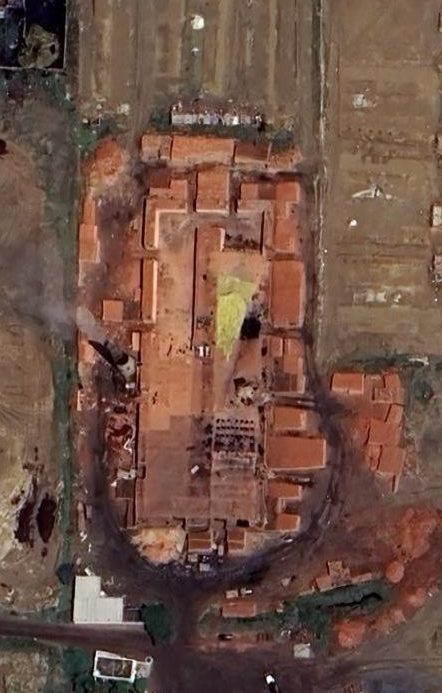

In [53]:
Image.open(files[1])

In [54]:
for file in tqdm(files):
    new_file = file.replace(".tif", ".png")
    with Image.open(file) as img:
        img.save(new_file)

  0%|          | 0/783 [00:00<?, ?it/s]

In [3]:
from ultralytics import YOLO

In [4]:
model = YOLO("yolo11m-obb")

In [5]:
model.train(data="../lab/trench_width/data.yaml", epochs=51, batch=-1, imgsz=1280, save_period=5)

New https://pypi.org/project/ultralytics/8.3.64 available 😃 Update with 'pip install -U ultralytics'


Ultralytics 8.3.55 🚀 Python-3.10.15 torch-2.5.0+cu124 CUDA:0 (NVIDIA A100-SXM4-80GB, 81156MiB)
engine/trainer: task=obb, mode=train, model=yolo11m-obb.pt, data=../lab/trench_width/data.yaml, epochs=51, time=None, patience=100, batch=-1, imgsz=1280, save=True, save_period=5, cache=False, device=None, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_con

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: patel_zeel (sustainability-lab). Use `wandb login --relogin` to force relogin


Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅


train: Scanning /home/patel_zeel/blog/lab/trench_width/labels.cache... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<?, ?it/s]

AutoBatch: Computing optimal batch size for imgsz=1280 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (NVIDIA A100-SXM4-80GB) 79.25G total, 0.21G reserved, 0.20G allocated, 78.84G free


      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
    20903385       287.6         4.488         46.53           nan      (1, 3, 1280, 1280)                    list
    20903385       575.1        10.364         44.88           nan      (2, 3, 1280, 1280)                    list
    20903385        1150        19.864         47.99           nan      (4, 3, 1280, 1280)                    list
    20903385        2300        39.047         75.16           nan      (8, 3, 1280, 1280)                    list
    20903385        4601        76.993         149.4           nan     (16, 3, 1280, 1280)                    list
CUDA out of memory. Tried to allocate 400.00 MiB. GPU 0 has a total capacity of 79.25 GiB of which 39.50 MiB is free. Including non-PyTorch memory, this process has 79.21 GiB memory in use. Of the allocated memory 78.52 GiB is allocated by PyTorch, and 164.18 MiB is reserved by PyTorch but unallocated. If res

train: Scanning /home/patel_zeel/blog/lab/trench_width/labels.cache... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<?, ?it/s]
val: Scanning /home/patel_zeel/blog/lab/trench_width/labels.cache... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<?, ?it/s]


Plotting labels to runs/obb/train5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 112 weight(decay=0.0), 122 weight(decay=0.00046875), 121 bias(decay=0.0)
Image sizes 1280 train, 1280 val
Using 8 dataloader workers
Logging results to runs/obb/train5
Starting training for 51 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/51      21.9G      3.042      5.112      3.885         57       1280: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

                   all         10         20    0.00146        0.2    0.00126   0.000148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/51      21.9G      2.846      4.908      4.012         58       1280: 100%|██████████| 1/1 [00:00<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

                   all         10         20    0.00106       0.15   0.000779   9.96e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/51      21.9G      3.022      5.258      3.667         56       1280: 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

                   all         10         20    0.00103       0.15   0.000764   9.76e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/51      21.9G      2.789      5.113      3.852         58       1280: 100%|██████████| 1/1 [00:00<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

                   all         10         20   0.000675        0.1   0.000516   7.25e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/51        22G      2.526       5.45      3.457         42       1280: 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

                   all         10         20     0.0017       0.25    0.00121    0.00022



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/51      22.1G      2.832      4.983      3.874         48       1280: 100%|██████████| 1/1 [00:00<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

                   all         10         20    0.00257       0.35    0.00268   0.000685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/51      22.1G      2.534      4.688      3.428         55       1280: 100%|██████████| 1/1 [00:00<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

                   all         10         20    0.00417       0.55     0.0161     0.0029



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/51      22.1G      2.091      4.292       3.43         56       1280: 100%|██████████| 1/1 [00:00<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

                   all         10         20    0.00667        0.6     0.0156    0.00451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/51      22.1G      2.307      4.644      3.652         35       1280: 100%|██████████| 1/1 [00:00<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

                   all         10         20     0.0105       0.55     0.0608     0.0119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/51      22.1G        1.8      4.124      2.982         47       1280: 100%|██████████| 1/1 [00:00<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]

                   all         10         20     0.0111        0.8     0.0696      0.017



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/51      22.1G      1.751      3.753      2.608         54       1280: 100%|██████████| 1/1 [00:00<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

                   all         10         20     0.0111        0.8     0.0696      0.017



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/51      22.2G      1.821      3.793      2.822         56       1280: 100%|██████████| 1/1 [00:00<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]

                   all         10         20    0.00953          1      0.145     0.0346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/51      22.1G      1.748       3.64      2.721         56       1280: 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

                   all         10         20    0.00953          1      0.145     0.0346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/51      22.2G      1.711      3.417      2.728         69       1280: 100%|██████████| 1/1 [00:00<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

                   all         10         20    0.00856          1      0.301      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/51      22.1G      1.443       3.42      3.097         45       1280: 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]

                   all         10         20    0.00856          1      0.301      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/51      22.2G      1.468      3.528      2.344         38       1280: 100%|██████████| 1/1 [00:00<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]

                   all         10         20       0.22       0.65      0.358      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/51      22.1G      1.452      2.938      2.311         54       1280: 100%|██████████| 1/1 [00:00<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

                   all         10         20       0.22       0.65      0.358      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/51      22.2G      1.321       2.94      3.078         46       1280: 100%|██████████| 1/1 [00:00<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

                   all         10         20      0.322        0.6      0.393       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/51      22.1G      1.385      2.793      2.518         53       1280: 100%|██████████| 1/1 [00:00<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

                   all         10         20      0.322        0.6      0.393       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/51      22.2G      1.287      2.709      2.337         46       1280: 100%|██████████| 1/1 [00:00<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.85it/s]

                   all         10         20      0.385        0.8       0.54      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/51      22.1G      1.191       2.52      2.295         56       1280: 100%|██████████| 1/1 [00:00<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]

                   all         10         20      0.385        0.8       0.54      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/51      22.2G      1.354      2.634      2.612         56       1280: 100%|██████████| 1/1 [00:00<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

                   all         10         20      0.463       0.85      0.708       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/51      22.1G      1.266      2.719       2.22         35       1280: 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

                   all         10         20      0.463       0.85      0.708       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/51      22.2G      1.189       2.15      2.245         59       1280: 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

                   all         10         20      0.479       0.85      0.729      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/51      22.1G      1.069      2.278      1.992         52       1280: 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

                   all         10         20      0.479       0.85      0.729      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/51      22.2G       1.42      2.523      2.593         54       1280: 100%|██████████| 1/1 [00:00<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

                   all         10         20      0.711        0.9      0.841       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/51      22.1G      1.175      2.119      1.997         56       1280: 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

                   all         10         20      0.711        0.9      0.841       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/51      22.2G      1.173      2.096      2.219         56       1280: 100%|██████████| 1/1 [00:00<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

                   all         10         20      0.856      0.889      0.933      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/51      22.1G      1.173      2.163      2.431         56       1280: 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]

                   all         10         20      0.856      0.889      0.933      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/51      22.2G      1.196      2.354      1.996         41       1280: 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]

                   all         10         20      0.856      0.889      0.933      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/51      22.2G      1.289      2.233      2.543         49       1280: 100%|██████████| 1/1 [00:00<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

                   all         10         20      0.971       0.89      0.966      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/51      22.1G       1.22      2.208      2.129         51       1280: 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]

                   all         10         20      0.971       0.89      0.966      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/51      22.2G      1.175      2.047      1.935         45       1280: 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

                   all         10         20      0.971       0.89      0.966      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/51      22.2G      1.268      1.903      1.914         62       1280: 100%|██████████| 1/1 [00:00<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]

                   all         10         20      0.806       0.93      0.952      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/51      22.1G      1.199      2.076       2.07         52       1280: 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]

                   all         10         20      0.806       0.93      0.952      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/51      22.2G      1.139      2.094      2.366         51       1280: 100%|██████████| 1/1 [00:00<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

                   all         10         20      0.806       0.93      0.952      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/51      22.2G      1.141      2.146      1.818         49       1280: 100%|██████████| 1/1 [00:00<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

                   all         10         20      0.768       0.94      0.946      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/51      22.1G      1.095      1.823      1.974         60       1280: 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]

                   all         10         20      0.768       0.94      0.946      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/51      22.2G      1.037      1.773      2.015         54       1280: 100%|██████████| 1/1 [00:00<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

                   all         10         20      0.768       0.94      0.946      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/51      22.2G      1.049      1.755      1.971         60       1280: 100%|██████████| 1/1 [00:00<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]

                   all         10         20       0.87       0.95      0.957      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/51      22.1G       1.16      2.066      2.284         46       1280: 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

                   all         10         20       0.87       0.95      0.957      0.669


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/51      22.2G      1.142      3.141      1.802         20       1280: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

                   all         10         20       0.87       0.95      0.957      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/51      22.2G      1.076      2.939      1.903         20       1280: 100%|██████████| 1/1 [00:00<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]

                   all         10         20      0.905       0.93      0.963      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/51      22.1G      1.062      2.816      1.615         20       1280: 100%|██████████| 1/1 [00:00<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

                   all         10         20      0.905       0.93      0.963      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/51      22.2G      1.043      2.889      1.868         20       1280: 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]

                   all         10         20      0.905       0.93      0.963      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/51      22.2G      1.308      3.073      1.914         20       1280: 100%|██████████| 1/1 [00:00<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]

                   all         10         20      0.895       0.95      0.957      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/51      22.1G     0.9313      2.941      1.799         20       1280: 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]

                   all         10         20      0.895       0.95      0.957      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/51      22.2G     0.9851      2.767      1.656         20       1280: 100%|██████████| 1/1 [00:00<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]

                   all         10         20      0.895       0.95      0.957      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/51      22.2G      1.306      2.876      2.089         20       1280: 100%|██████████| 1/1 [00:00<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

                   all         10         20      0.895       0.95      0.957      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/51      22.2G      1.156      2.817      1.904         20       1280: 100%|██████████| 1/1 [00:00<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

                   all         10         20      0.913      0.999      0.968      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/51      22.1G      1.119      2.846      1.677         20       1280: 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]

                   all         10         20      0.913      0.999      0.968      0.726



51 epochs completed in 0.034 hours.
Optimizer stripped from runs/obb/train5/weights/last.pt, 43.1MB
Optimizer stripped from runs/obb/train5/weights/best.pt, 43.1MB

Validating runs/obb/train5/weights/best.pt...
Ultralytics 8.3.55 🚀 Python-3.10.15 torch-2.5.0+cu124 CUDA:0 (NVIDIA A100-SXM4-80GB, 81156MiB)
YOLO11m-obb summary (fused): 322 layers, 20,880,025 parameters, 0 gradients, 71.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


                   all         10         20      0.913      0.999      0.968      0.734
             inner_box         10         10      0.909      0.998       0.94      0.592
             outer_box         10         10      0.918          1      0.995      0.875
Speed: 0.4ms preprocess, 6.9ms inference, 0.0ms loss, 54.4ms postprocess per image
Results saved to runs/obb/train5


lr/pg0,▁▂▂▃▃▄▄▅▅▅▆▆▇▇▇██████████▇▇▇▇▇▆▆▆▅▅▄▄▃▃▂
lr/pg1,▁▂▂▃▃▄▄▅▅▅▆▆▇▇▇▇█████████▇▇▇▇▇▆▆▆▅▅▄▄▃▃▂
lr/pg2,▁▂▃▃▃▄▅▅▅▆▆▇▇▇▇███████████▇▇▇▇▆▆▆▅▅▄▄▃▃▂
metrics/mAP50(B),▁▁▁▁▁▁▁▂▂▃▄▄▄▄▅▆▆▆▆▇████████████████████
metrics/mAP50-95(B),▁▁▁▁▁▁▁▁▁▁▂▂▂▂▃▃▅▅▅▅▆▇▇▇▇▇███▇▇▇▇▇██████
metrics/precision(B),▁▁▁▁▁▁▁▁▁▁▁▁▁▃▃▃▄▄▄▄▄▆▇▇▇█▇▇▇▇▇▇▇▇██▇▇▇█
metrics/recall(B),▁▁▁▂▃▅▄▆▆███▅▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████▇▇████
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▇█▇▆▆▅▆▄▄▄▄▃▃▃▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▂▁▁▂▂


ultralytics.utils.metrics.OBBMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fe64f199420>
curves: []
curves_results: []
fitness: np.float64(0.7570705318296267)
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
maps: array([    0.59184,     0.87549])
names: {0: 'inner_box', 1: 'outer_box'}
plot: True
results_dict: {'metrics/precision(B)': np.float64(0.9134993192895953), 'metrics/recall(B)': np.float64(0.9987569029703861), 'metrics/mAP50(B)': np.float64(0.9677272727272728), 'metrics/mAP50-95(B)': np.float64(0.7336642272854437), 'fitness': np.float64(0.7570705318296267)}
save_dir: PosixPath('runs/obb/train5')
speed: {'preprocess': 0.35784244537353516, 'inference': 6.9373369216918945, 'loss': 0.0010251998901367188, 'postprocess': 54.367613792419434}

## Predict

In [6]:
import numpy as np
import supervision as sv
pred_model = YOLO("/home/patel_zeel/blog/lab/runs/obb/train5/weights/best.pt")

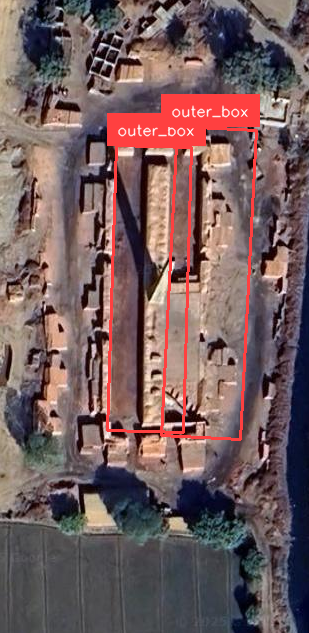

In [19]:
import os
files = glob("/home/patel_zeel/kiln_compass_24/regions/high_res/19/*.png")
# np.random.seed(1)
random_file = np.random.choice(files)
base_name = os.path.basename(random_file)
if base_name in [os.path.basename(file) for file in glob("../lab/trench_width/images/*.png")]:
    print("Part of the training dataset")

result = pred_model(random_file, imgsz=1280, verbose=False)[0]
detection = sv.Detections.from_ultralytics(result)

img = Image.open(random_file)
box_annotator = sv.OrientedBoxAnnotator()
label_annotator = sv.LabelAnnotator()
annotated_image = box_annotator.annotate(img.copy(), detection)
annotated_image = label_annotator.annotate(annotated_image, detection)
display(annotated_image)

## Run seg

In [23]:
model = YOLO("yolov8m-seg")

In [24]:
model.train(data="../lab/trench_width/data.yaml", epochs=51, batch=-1, imgsz=1280, save_period=5)

New https://pypi.org/project/ultralytics/8.3.64 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.55 🚀 Python-3.10.15 torch-2.5.0+cu124 CUDA:0 (NVIDIA A100-SXM4-80GB, 81156MiB)
engine/trainer: task=segment, mode=train, model=yolov8m-seg.pt, data=../lab/trench_width/data.yaml, epochs=51, time=None, patience=100, batch=-1, imgsz=1280, save=True, save_period=5, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, sho

Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅


train: Scanning /home/patel_zeel/blog/lab/trench_width/labels.cache... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<?, ?it/s]

AutoBatch: Computing optimal batch size for imgsz=1280 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (NVIDIA A100-SXM4-80GB) 79.25G total, 3.34G reserved, 0.75G allocated, 75.16G free


      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
    27240806       441.6         4.140         29.42           nan      (1, 3, 1280, 1280)                    list
    27240806       883.2         9.200         36.04           nan      (2, 3, 1280, 1280)                    list
    27240806        1766        17.132         41.55           nan      (4, 3, 1280, 1280)                    list
    27240806        3533        33.320          73.9           nan      (8, 3, 1280, 1280)                    list
    27240806        7065        64.274         142.8           nan     (16, 3, 1280, 1280)                    list
    27240806   1.413e+04       127.767         281.6           nan     (32, 3, 1280, 1280)                    list
CUDA out of memory. Tried to allocate 600.00 MiB. GPU 0 has a total capacity of 79.25 GiB of which 167.50 MiB is free. Including non-PyTorch memory, this process has 79.07 GiB memory in use. Of t

train: Scanning /home/patel_zeel/blog/lab/trench_width/labels.cache... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<?, ?it/s]
val: Scanning /home/patel_zeel/blog/lab/trench_width/labels.cache... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.000515625), 96 bias(decay=0.0)
Image sizes 1280 train, 1280 val
Using 8 dataloader workers
Logging results to runs/segment/train
Starting training for 51 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/51      19.4G      2.736      7.179      6.442      2.486         57       1280: 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]

                   all         10         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/51      19.4G      2.783      6.387      6.172      2.612         59       1280: 100%|██████████| 1/1 [00:00<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.37it/s]

                   all         10         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/51      19.4G      2.929      7.076      6.595      2.577         56       1280: 100%|██████████| 1/1 [00:00<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]

                   all         10         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/51      19.4G      2.726      7.228      6.208      2.532         58       1280: 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.10it/s]

                   all         10         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/51      19.3G      2.499      6.182      7.267      2.396         42       1280: 100%|██████████| 1/1 [00:00<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]

                   all         10         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/51      19.3G      3.034      8.223      7.171      2.728         48       1280: 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]

                   all         10         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/51      19.4G       3.12      7.957      7.105      2.859         55       1280: 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]

                   all         10         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/51      19.4G      2.931      7.516      6.602      2.776         56       1280: 100%|██████████| 1/1 [00:00<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]

                   all         10         20      0.696       0.15      0.145     0.0523      0.617        0.2     0.0585     0.0102



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/51      19.4G      2.629      5.092      6.662      2.429         35       1280: 100%|██████████| 1/1 [00:00<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]

                   all         10         20       0.13       0.25       0.16     0.0768      0.132        0.1      0.154     0.0326



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/51      19.5G      1.897      4.349      4.317      1.925         48       1280: 100%|██████████| 1/1 [00:00<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]

                   all         10         20      0.452      0.351       0.39      0.175      0.172       0.35       0.25     0.0854



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/51      19.6G      1.887      4.137      3.486      1.877         54       1280: 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]

                   all         10         20        0.8       0.15      0.357      0.219      0.105      0.614      0.284     0.0629



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/51      19.6G       1.43      3.731      3.628      1.507         56       1280: 100%|██████████| 1/1 [00:00<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.44it/s]

                   all         10         20        0.8       0.15      0.357      0.219      0.105      0.614      0.284     0.0629



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/51      19.7G      1.559      3.545       3.55      1.526         56       1280: 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.00it/s]

                   all         10         20      0.904        0.3        0.5      0.193      0.904        0.3       0.43      0.108



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/51      19.7G       1.39      2.989      2.648      1.478         69       1280: 100%|██████████| 1/1 [00:00<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.83it/s]

                   all         10         20      0.904        0.3        0.5      0.193      0.904        0.3       0.43      0.108



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/51      19.6G      1.729      2.974      3.255      1.676         45       1280: 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]

                   all         10         20      0.455      0.727      0.398      0.158      0.451      0.677      0.349      0.137



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/51      19.4G      1.711      2.639      3.226      1.627         38       1280: 100%|██████████| 1/1 [00:00<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]

                   all         10         20      0.455      0.727      0.398      0.158      0.451      0.677      0.349      0.137



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/51      19.7G      1.329      2.381      2.383      1.373         54       1280: 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]

                   all         10         20      0.284       0.75      0.629      0.298      0.299        0.8      0.649      0.261



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/51      19.4G      1.228      1.977      2.472      1.299         46       1280: 100%|██████████| 1/1 [00:00<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]

                   all         10         20      0.284       0.75      0.629      0.298      0.299        0.8      0.649      0.261



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/51      19.7G      1.415      2.453      2.654      1.415         54       1280: 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]

                   all         10         20      0.792       0.35      0.358      0.212      0.792       0.35      0.346      0.179



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/51      19.5G      1.282      1.927      2.378      1.391         46       1280: 100%|██████████| 1/1 [00:00<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]

                   all         10         20      0.792       0.35      0.358      0.212      0.792       0.35      0.346      0.179



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      21/51      19.7G      1.192      1.933       2.26       1.32         56       1280: 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

                   all         10         20      0.474        0.5      0.538      0.356      0.474        0.5      0.539      0.285



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      22/51      19.6G      1.181      1.726      2.088      1.278         56       1280: 100%|██████████| 1/1 [00:00<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

                   all         10         20      0.474        0.5      0.538      0.356      0.474        0.5      0.539      0.285



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      23/51      19.4G        1.3      2.048      2.568      1.359         35       1280: 100%|██████████| 1/1 [00:00<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.50it/s]

                   all         10         20      0.778        0.6      0.659      0.352      0.722       0.55      0.637      0.374



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      24/51      19.6G       1.12      1.541      1.564      1.297         60       1280: 100%|██████████| 1/1 [00:00<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]

                   all         10         20      0.778        0.6      0.659      0.352      0.722       0.55      0.637      0.374



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      25/51      19.6G      1.043      1.471      1.694      1.228         52       1280: 100%|██████████| 1/1 [00:00<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]

                   all         10         20      0.415        0.7      0.443      0.248      0.436       0.75      0.445      0.307



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      26/51      19.5G      1.355       1.56      1.975       1.43         54       1280: 100%|██████████| 1/1 [00:00<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.66it/s]

                   all         10         20      0.415        0.7      0.443      0.248      0.436       0.75      0.445      0.307



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      27/51      19.7G       1.02      1.483      1.475      1.218         56       1280: 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.42it/s]

                   all         10         20      0.771       0.55      0.749      0.416      0.771       0.55       0.76       0.51



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      28/51      19.6G      1.079      1.262      1.616      1.309         56       1280: 100%|██████████| 1/1 [00:00<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.32it/s]

                   all         10         20      0.771       0.55      0.749      0.416      0.771       0.55       0.76       0.51



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      29/51      19.7G      1.093      1.497      1.691      1.302         56       1280: 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.35it/s]

                   all         10         20      0.774       0.75      0.799      0.436      0.774       0.75      0.788      0.514



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      30/51      19.5G      1.135      1.419      1.848      1.339         42       1280: 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.87it/s]

                   all         10         20      0.774       0.75      0.799      0.436      0.774       0.75      0.788      0.514



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      31/51      19.6G      1.042      1.496      1.698      1.272         50       1280: 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.63it/s]


                   all         10         20      0.632        0.7      0.652      0.429      0.663       0.75      0.698      0.501

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      32/51      19.6G       1.05      1.488      1.513      1.214         52       1280: 100%|██████████| 1/1 [00:00<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.62it/s]

                   all         10         20      0.632        0.7      0.652      0.429      0.663       0.75      0.698      0.501



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      33/51      19.6G      1.043      1.309       1.44      1.269         45       1280: 100%|██████████| 1/1 [00:00<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


                   all         10         20      0.632        0.7      0.652      0.429      0.663       0.75      0.698      0.501

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      34/51      19.7G     0.9872      1.389      1.329      1.191         62       1280: 100%|██████████| 1/1 [00:00<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.38it/s]

                   all         10         20      0.646        0.7      0.724      0.512      0.713        0.8      0.763       0.58



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      35/51      19.6G      1.019      1.202      1.568      1.191         52       1280: 100%|██████████| 1/1 [00:00<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.40it/s]

                   all         10         20      0.646        0.7      0.724      0.512      0.713        0.8      0.763       0.58



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      36/51      19.6G      1.029       1.35      1.522      1.232         51       1280: 100%|██████████| 1/1 [00:00<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.22it/s]

                   all         10         20      0.646        0.7      0.724      0.512      0.713        0.8      0.763       0.58



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      37/51      19.6G      1.056      1.289      1.494      1.221         50       1280: 100%|██████████| 1/1 [00:00<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.64it/s]


                   all         10         20      0.635       0.85      0.803        0.6       0.69        0.9      0.846      0.657

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      38/51      19.6G     0.8953      1.298       1.12      1.068         60       1280: 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.65it/s]


                   all         10         20      0.635       0.85      0.803        0.6       0.69        0.9      0.846      0.657

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      39/51      19.6G     0.8898      1.057      1.206      1.153         54       1280: 100%|██████████| 1/1 [00:00<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.70it/s]


                   all         10         20      0.635       0.85      0.803        0.6       0.69        0.9      0.846      0.657

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      40/51      19.7G     0.9538      1.113      1.201      1.206         60       1280: 100%|██████████| 1/1 [00:00<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.69it/s]


                   all         10         20      0.736        0.8       0.85      0.621      0.812        0.9      0.919      0.683

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      41/51      19.5G     0.9001      1.213      1.314      1.171         46       1280: 100%|██████████| 1/1 [00:00<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.36it/s]

                   all         10         20      0.736        0.8       0.85      0.621      0.812        0.9      0.919      0.683


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      42/51      19.3G      1.192      1.432      2.694      1.399         20       1280: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]

                   all         10         20      0.736        0.8       0.85      0.621      0.812        0.9      0.919      0.683



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      43/51      19.3G      1.034      1.252      2.616      1.418         20       1280: 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.62it/s]

                   all         10         20      0.814       0.85      0.876      0.651      0.866        0.9      0.931      0.702



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      44/51      19.2G     0.9355      1.308       2.01       1.27         20       1280: 100%|██████████| 1/1 [00:00<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.74it/s]

                   all         10         20      0.814       0.85      0.876      0.651      0.866        0.9      0.931      0.702



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      45/51      19.3G     0.9141      1.258      2.125      1.412         20       1280: 100%|██████████| 1/1 [00:00<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.62it/s]


                   all         10         20      0.814       0.85      0.876      0.651      0.866        0.9      0.931      0.702

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      46/51      19.3G      1.256      1.421      2.302      1.435         20       1280: 100%|██████████| 1/1 [00:00<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.75it/s]

                   all         10         20      0.782      0.829       0.84        0.6      0.804      0.819      0.881      0.687



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      47/51      19.2G     0.8384      1.046      1.981      1.267         20       1280: 100%|██████████| 1/1 [00:00<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.70it/s]


                   all         10         20      0.782      0.829       0.84        0.6      0.804      0.819      0.881      0.687

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      48/51      19.3G      1.146      1.197      2.063      1.319         20       1280: 100%|██████████| 1/1 [00:00<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.71it/s]


                   all         10         20      0.782      0.829       0.84        0.6      0.804      0.819      0.881      0.687

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      49/51      19.3G      1.144      1.099      2.118      1.411         20       1280: 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.79it/s]

                   all         10         20      0.811      0.776      0.909      0.675      0.797      0.879      0.926      0.728



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      50/51      19.2G      1.022      1.027      1.993      1.325         20       1280: 100%|██████████| 1/1 [00:00<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.60it/s]


                   all         10         20      0.811      0.776      0.909      0.675      0.797      0.879      0.926      0.728

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      51/51      19.3G      1.167      1.066        2.1      1.344         20       1280: 100%|██████████| 1/1 [00:00<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.51it/s]

                   all         10         20      0.811      0.776      0.909      0.675      0.797      0.879      0.926      0.728



51 epochs completed in 0.031 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 55.0MB
Optimizer stripped from runs/segment/train/weights/best.pt, 55.0MB

Validating runs/segment/train/weights/best.pt...
Ultralytics 8.3.55 🚀 Python-3.10.15 torch-2.5.0+cu124 CUDA:0 (NVIDIA A100-SXM4-80GB, 81156MiB)
YOLOv8m-seg summary (fused): 245 layers, 27,223,542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.44it/s]


                   all         10         20      0.811      0.776      0.909      0.675      0.797      0.879      0.926      0.727
             inner_box         10         10      0.622        0.7      0.823      0.508      0.594        0.8      0.857      0.678
             outer_box         10         10          1      0.852      0.995      0.842          1      0.959      0.995      0.776
Speed: 0.4ms preprocess, 6.9ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs/segment/train


lr/pg0,▁▂▂▃▃▄▄▅▅▅▆▆▇▇▇▇███████████▇▇▇▇▆▆▆▆▅▄▄▃▂
lr/pg1,▁▂▂▃▃▄▅▅▅▆▆▇▇▇▇████████████▇▇▇▆▆▆▆▅▄▄▄▃▂
lr/pg2,▁▂▂▃▃▄▄▅▅▅▆▆▇▇▇▇███████████▇▇▇▆▆▆▆▅▄▄▄▃▂
metrics/mAP50(B),▁▁▁▁▂▄▄▄▅▅▄▆▆▄▄▅▆▆▄▄▇▇▇▆▆▇▇▇▇▇█████▇▇▇██
metrics/mAP50(M),▁▁▁▁▁▁▁▂▃▃▄▄▄▆▄▅▅▆▆▄▇▇▇▇▆▇▇▇▇▇██████████
metrics/mAP50-95(B),▁▁▁▁▁▁▂▂▃▃▃▃▃▃▄▃▃▅▅▅▄▅▅▆▆▅▅▆▆▆▇▇▇▇██▇▇██
metrics/mAP50-95(M),▁▁▁▁▁▁▁▁▂▂▂▂▂▂▄▃▄▄▅▅▄▆▆▆▆▆▇▇▇▇██████████
metrics/precision(B),▁▁▁▁▁▇▂▅██▅▅▃▃█▅██▅▅███▆▆▇▇▇▆▆▇▇▇███████
metrics/precision(M),▁▁▁▁▁▆▂▂▂▂█▄▄▃▃▇▅▅▇▄▇▇▇▇▆▆▇▇▇▆▆▇▇▇██▇▇▇▇
metrics/recall(B),▁▁▁▁▁▃▄▂▂▃▇▇▇▇▄▅▅▆▆▇▆▇▇▇▇▇▇▇██████████▇▇
metrics/recall(M),▁▁▁▁▁▃▂▄▆▆▃▆▆▇▇▅▅▅▅▇▅▅▇▇▇▇▇▇▇███████▇▇██


ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fe84e12c040>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.04104

## Predict

In [25]:
import numpy as np
import supervision as sv
pred_model = YOLO("/home/patel_zeel/blog/lab/runs/segment/train/weights/best.pt")

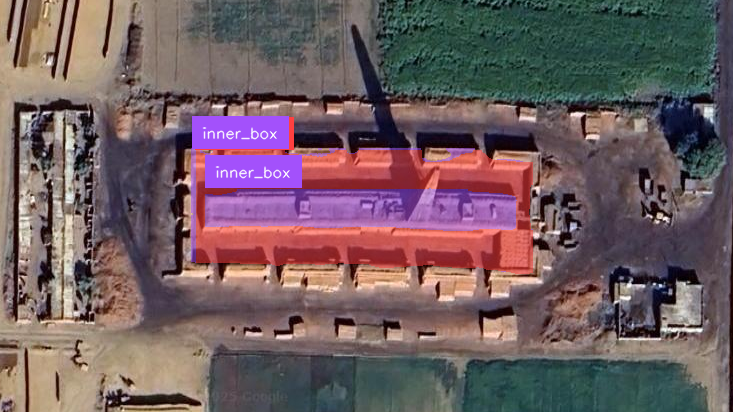

In [44]:
import os
files = glob("/home/patel_zeel/kiln_compass_24/regions/high_res/19/*.png")
# np.random.seed(1)
random_file = np.random.choice(files)
base_name = os.path.basename(random_file)
if base_name in [os.path.basename(file) for file in glob("../lab/trench_width/images/*.png")]:
    print("Part of the training dataset")

result = pred_model(random_file, imgsz=1280, verbose=False)[0]
detection = sv.Detections.from_ultralytics(result)

img = Image.open(random_file)
box_annotator = sv.MaskAnnotator()
label_annotator = sv.LabelAnnotator()
annotated_image = box_annotator.annotate(img.copy(), detection)
annotated_image = label_annotator.annotate(annotated_image, detection)
display(annotated_image)